## could to make these functions:
1. for chessboard could analyze cover time vs which vertex we start at - very likely inversely proportional to degree of starting vertex
    1. could do this for any graph really: could be a function.  could define some measure
2. pull out class and imports into a .py file (but sourcing was annoying for compression)
   1. keep different ipynb for each class of problem, eg. chess file, then other random stuff for thesis, then classic graphs
5. make star graph
6. make lollipop graph
7. make generalized star graph
8. make random graph with n vertices, m edges
9. do heat map on chessboard where we start 1000 times per vertex, keep track of which vertex was hit in what order
    1. i guess you would need to keep the vertices in a list instead of set for the cover walk.  lets put this lower on the priority list


In [1]:
import numpy as np
import graphviz
import random
import math
import matplotlib.pyplot as plt
import shutil
import cairosvg
from PIL import Image
from IPython.display import IFrame
from IPython.display import SVG, display

In [2]:
def make_complete_graph(n):
    graph_dict = {}
    for i in range(n):
        graph_dict[i] = []
        for j in range(n-1):
            graph_dict[i].append((i + j + 1) % n)
    return graph_dict


def make_cycle_graph(n):
    graph_dict = {}
    for i in range(n):
        graph_dict[i] = []
        graph_dict[i].append((i + 1) % n)
        graph_dict[i].append((i - 1) % n)
    return graph_dict

def make_linear_graph(n):
    graph_dict = {}
    for i in range(n-1):
        graph_dict[i] = []
        graph_dict[i].append(i + 1)
    graph_dict[n-1] = []
    for i in range(n-1):
        graph_dict[i+1].append(i)
    return graph_dict

In [3]:
def is_valid_move(x, y, n):
    """Check if the move is within bounds"""
    return 0 <= x < n and 0 <= y < n

# adapted from https://medium.com/@davidlfliang/intro-python-algorithms-knights-tour-problem-ab0a27a5728c
# got a little help with GPT to adapt to king, rook, queen eficiently
def make_chessboard_dict(n, chesspiece = "knight"):
    
    assert chesspiece in {"knight", "king", "rook", "queen"}, "Valid Chesspieces are Knight, King, Rook, Queen"
    
    moves = {
        "knight": [
            (2, 1), (1, 2), (-1, 2), (-2, 1),
            (-2, -1), (-1, -2), (1, -2), (2, -1)
        ],
        "king": [
            (1, 0), (0, 1), (-1, 0), (0, -1),
            (1, 1), (-1, 1), (-1, -1), (1, -1)
        ],
        "rook": [
            (1, 0), (0, 1), (-1, 0), (0, -1)
        ],
        "queen": [
            (1, 0), (0, 1), (-1, 0), (0, -1),
            (1, 1), (-1, 1), (-1, -1), (1, -1)
        ]
    }
    
    graph_dict = {}
    piece_moves = moves[chesspiece]

    for i in range(n * n):
        x = i % n
        y = i // n

        graph_dict[i] = []
        
        for dx, dy in piece_moves:
            step = 1
            while True:
                new_x, new_y = x + dx * step, y + dy * step
                if is_valid_move(new_x, new_y, n):
                    graph_dict[i].append(new_y * n + new_x)
                    if chesspiece in {"king", "knight"}:  # these do not repeat moves
                        break
                    step += 1
                else:
                    break

    return graph_dict

In [4]:
def create_gif(svg_files, output_gif, length = 10):
    """Creates a GIF from a list of SVG files."""

    # Convert SVGs to PNGs
    png_files = []
    for svg_file in svg_files:
        png_file = svg_file.replace('.svg', '.png')
        cairosvg.svg2png(url=svg_file, write_to=png_file)
        png_files.append(png_file)

    # Create GIF using PIL
    images = [Image.open(png_file) for png_file in png_files]
    images[0].save(
        output_gif, 
        save_all=True, 
        append_images=images[1:], 
        optimize=False, 
        duration= int((length * 1000) / len(svg_files)), 
        loop=0 
    )

# want to create tmp folder of svg files then once we have a gif delete that 



In [5]:
class Graph(object):

    def __init__(self, graph_dict, graph_type = "user"):
        self.dict = graph_dict
        self.n = len(graph_dict.keys())
        self.graph_type = graph_type
        self.engine = self.map_engine()
        self.graphviz = self.make_graphviz()


    @classmethod
    def make_classic(cls, n, graph_type):
        graph_dict = {}
        
        if graph_type == "complete":
            graph_dict = make_complete_graph(n)
        elif graph_type == "cycle":
            graph_dict = make_cycle_graph(n)
        elif graph_type == "linear":
            graph_dict = make_linear_graph(n)

        return cls(graph_dict, graph_type)


    def map_engine(self):
        engine_dict = {"complete": "circo", "cycle": "circo", "linear": "dot", "user": "neato"}
        return engine_dict[self.graph_type] if self.graph_type in engine_dict.keys() else "neato"

    
    # develop flags for different types of graphs like an int flag
    def make_graphviz(self):
        
        g = graphviz.Graph(engine = self.engine) #
        keys = list(self.dict.keys())
        visited = []

        g.attr('node', width='0.4', height='0.4', fixedsize='true', fontsize='8')
        
        if self.graph_type == "linear":
            g.attr(rankdir='LR')  # Left to Right layout

        for i in range(len(keys)):
            a = keys[i]
            for j in range(len(self.dict[a])):
                if (self.dict[a][j], a) not in visited:
                    g.edge(str(a), str(self.dict[a][j]))
                    visited.append((a, self.dict[a][j]))
        return g

    def make_path_gif(self, gif_length = None, path = None):
        if path == None:
            path = g.cover_walk()

        if gif_length == None:
            gif_length = self.n


        # if not there, regular
        # if there and filled in:
        # gray and 
        #self.graphviz.node('2', color = 'green', style = 'filled', fillcolor='gray', penwidth = '3')
        #self.graphviz.node('3', style = 'filled', fillcolor='gray')
        #self.graphviz.node('4', color = 'green', penwidth = '3')

        #svg_path = 'temp'
        filepaths = []
        visited = set()

        for i in range(len(path)):
            svg_path = 'temp/' + str(i)
            filepaths.append(svg_path + '.svg')

            #current point
            if path[i] not in visited:
                self.graphviz.node(str(path[i]), color = 'green', penwidth = '3')

                self.graphviz.render(svg_path, format='svg', cleanup=True)


              

                visited.add(path[i])

            else:
                self.graphviz.node(str(path[i]), color = 'green', style = 'filled', fillcolor='gray', penwidth = '3')
                   
                self.graphviz.render(svg_path, format='svg', cleanup=True)

            self.graphviz.node(str(path[i]), style = 'filled', fillcolor = 'gray', color = 'black', penwidth = '1')

        for vertex in visited:
            self.graphviz.node(str(vertex), color = 'black', fillcolor = 'transparent', penwdith = '1')
        
            #self.graphviz.node(str(path[i]), color = 'black', penwidth = '1')

        
        
        create_gif(filepaths, "output.gif", gif_length)

        shutil.rmtree("temp")

        # at the end make all vertices normal again
    
    def display(self):
        svg_path = 'temp'
        self.graphviz.render(svg_path, format='svg', cleanup=True)
        display(SVG(svg_path + ".svg"))

    def export_png(self, filename = "export"):
        self.graphviz.attr(dpi='300')
        self.graphviz.render(filename, format='png', cleanup=True)


    def cover_walk(self, starting_vertex = None, print_out = True):
        if (starting_vertex == None):
            starting_vertex = list(self.dict.keys())[0]

        if (starting_vertex < 0 or starting_vertex > self.n):
            raise ValueError("The starting vertex cannot be negative or higher than n.")

        path = [starting_vertex] 

        visited = set()
        visited.add(starting_vertex)



        cur = starting_vertex

        while len(visited) != self.n:
            next_vertex = random.choice(self.dict[cur])
            path.append(next_vertex)
            visited.add(next_vertex)

            cur = next_vertex

        if print_out:
            print("Cover Time: " + str(len(path)))
            print(path)
            
        return path


    # make partial cover walk for time to reach n unique vertices

    # make avergaging functions for this where it runs it a bunch

    def avg_cover_walk(self, n, starting_vertex = None, bin_size = None, filename = ""):
        # make histogram and display 
        lengths = [len(self.cover_walk(starting_vertex, False)) for _ in range(n)]
        
        if bin_size == None:
            plt.hist(lengths)
        else:
            plt.hist(lengths, bins=range(min(lengths), max(lengths) + 1, bin_size))



        plt.title("Average cover time starting at vertex " + str(starting_vertex) + ": " + str(round(sum(lengths) / n, 2)))
        plt.xlabel("Length of random walk")
        plt.ylabel("Frequency")
        plt.savefig(filename + self.graph_type + str(self.n) + "_" + str(n) + "iter" + ".png", bbox_inches = "tight")
        plt.show()

        return sum(lengths) / n
            
        

            

In [6]:
g = Graph.make_classic(10, "cycle")
#g.display()

g.make_path_gif()

Cover Time: 92
[0, 9, 8, 7, 8, 9, 0, 1, 0, 1, 0, 9, 8, 9, 0, 9, 0, 1, 2, 3, 2, 3, 2, 1, 2, 3, 2, 1, 2, 1, 0, 1, 2, 3, 4, 3, 4, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 1, 2, 1, 2, 1, 0, 1, 0, 1, 0, 1, 0, 9, 8, 7, 6, 7, 6, 7, 8, 9, 0, 1, 0, 1, 0, 9, 0, 9, 8, 9, 8, 9, 0, 9, 0, 9, 8, 7, 6, 7, 8, 7, 6, 5]


In [7]:
g.make_path_gif()

Cover Time: 52
[0, 1, 0, 1, 2, 3, 4, 3, 2, 3, 2, 3, 4, 3, 2, 1, 2, 3, 4, 3, 4, 5, 4, 5, 4, 5, 4, 5, 6, 5, 4, 3, 4, 3, 4, 3, 4, 3, 2, 3, 4, 3, 2, 1, 0, 1, 2, 1, 0, 9, 8, 7]


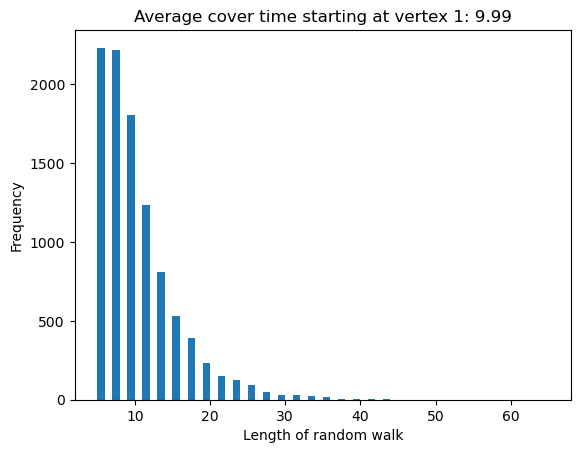

9.995

In [8]:
star_graph_dict = {1: [2], 2: [1,3,4], 3: [2], 4: [2]}
t = Graph(star_graph_dict)

t.avg_cover_walk(n = 10000, starting_vertex = 1, bin_size = 1)

In [9]:
t.graphviz.node("1", color = 'green', penwidth = '3')
t.export_png()

In [10]:
path = t.cover_walk(1)
t.make_path_gif(t.n, path)

Cover Time: 9
[1, 2, 4, 2, 4, 2, 4, 2, 3]


In [11]:
path_graph_dict = {0: [1], 1: [0,2], 2: [1,3], 3: [2,4], 4: [3,5], 5: [4]}
p = Graph(path_graph_dict, graph_type = "linear")
p.export_png()

In [12]:
c = Graph.make_classic(7, "cycle")
c.export_png()

In [13]:
k = Graph.make_classic(5, "complete")
k.export_png()

In [14]:
star_graph_dict = {0: [1,3,5,7], 1: [0,2], 3: [0, 4], 5: [0,6], 7: [0,8], 2: [1], 4: [3], 6: [5], 8: [7]}
s = Graph(star_graph_dict, graph_type = "user")
s.export_png("exports/star_example")

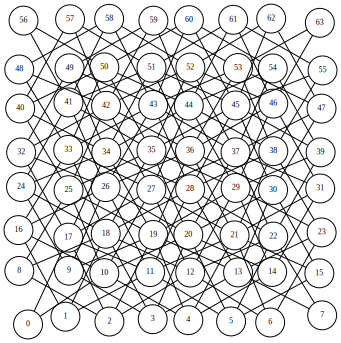

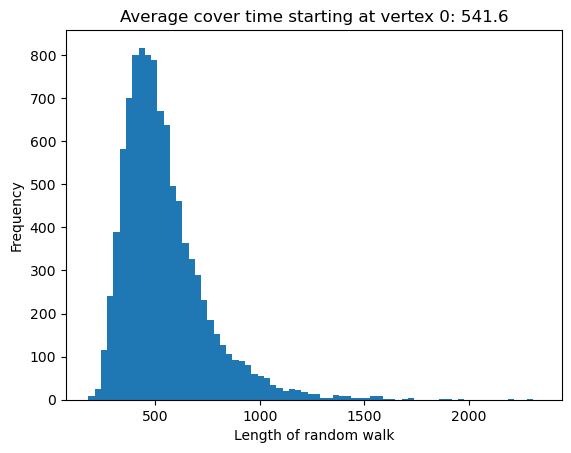

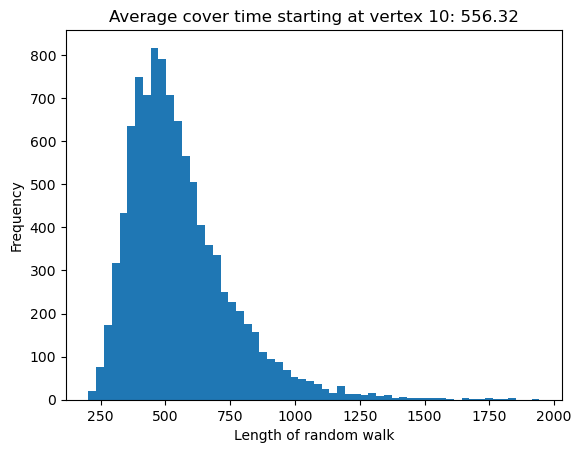

556.3233

In [15]:
knight = Graph(make_chessboard_dict(8, "knight"))
knight.display()
knight.export_png("exports/chess/knight_graph")

# start in corner
knight.avg_cover_walk(n = 10000, starting_vertex = 0, bin_size = 30, filename = "exports/chess/knight_corner")

# start in middle
knight.avg_cover_walk(n = 10000, starting_vertex = 10, bin_size = 30, filename = "exports/chess/knight_middle")

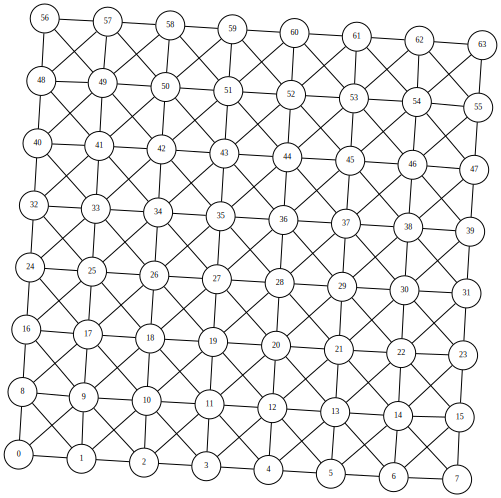

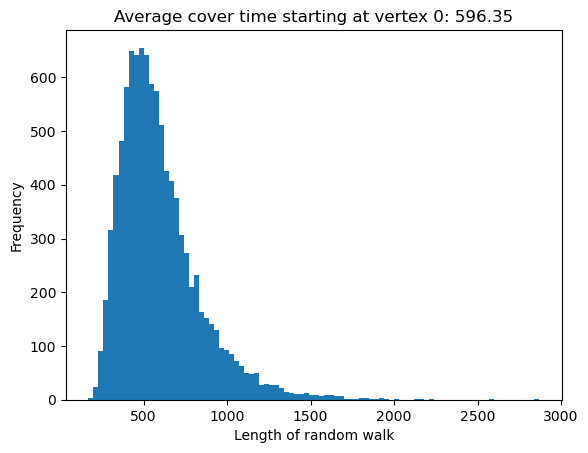

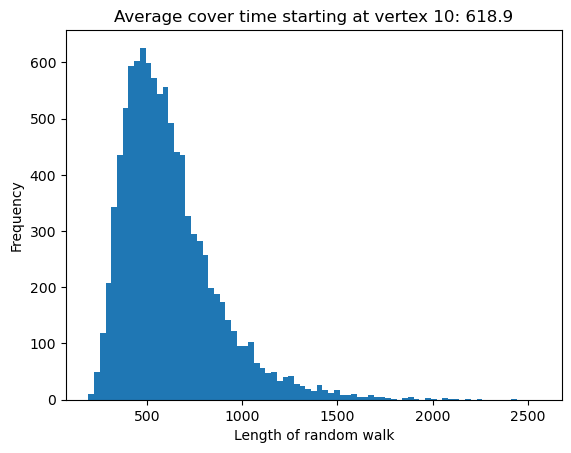

618.8989

In [16]:
king = Graph(make_chessboard_dict(8, "king"))
king.display()
king.export_png("exports/chess/king_graph")

# start in corner
king.avg_cover_walk(n = 10000, starting_vertex = 0, bin_size = 30, filename = "exports/chess/king_corner")

# start in middle
king.avg_cover_walk(n = 10000, starting_vertex = 10, bin_size = 30, filename = "exports/chess/king_middle")

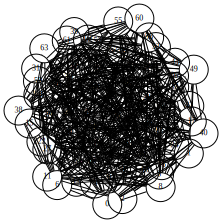

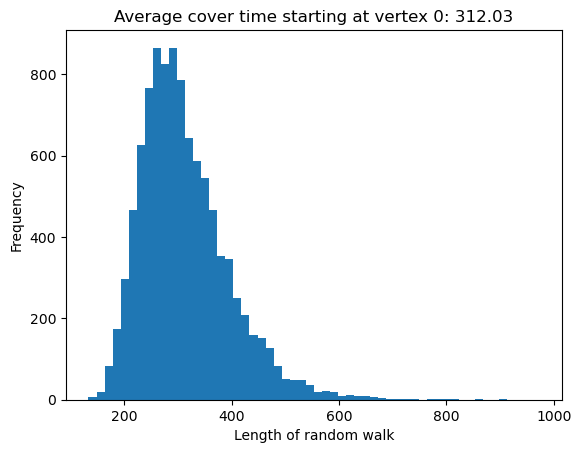

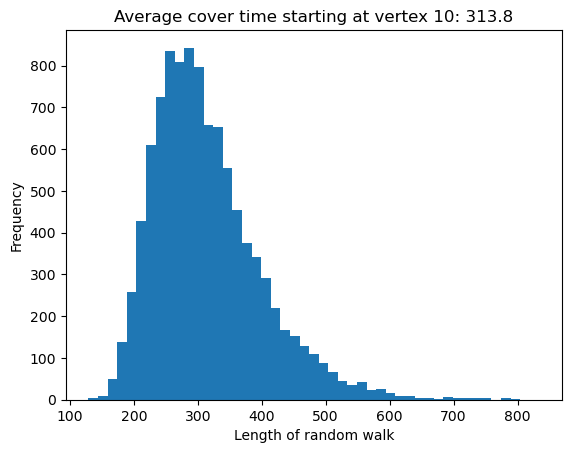

313.7959

In [17]:
queen = Graph(make_chessboard_dict(8, "queen"))
queen.display()

# start in corner
queen.avg_cover_walk(n = 10000, starting_vertex = 0, bin_size = 15, filename = "exports/chess/queen_corner")

# start in middle
queen.avg_cover_walk(n = 10000, starting_vertex = 10, bin_size = 15, filename = "exports/chess/queen_middle")

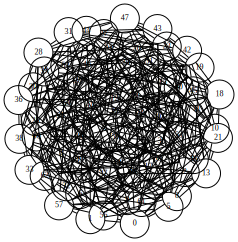

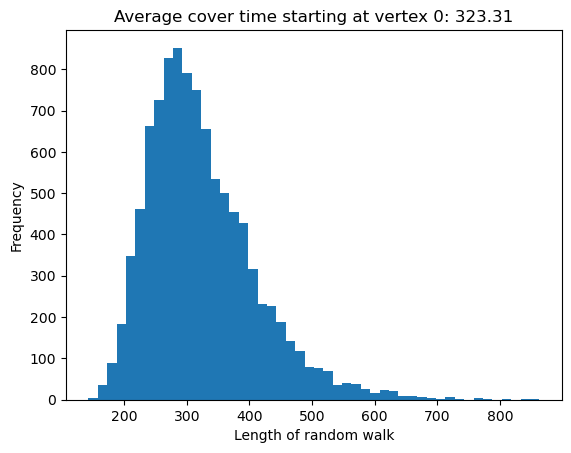

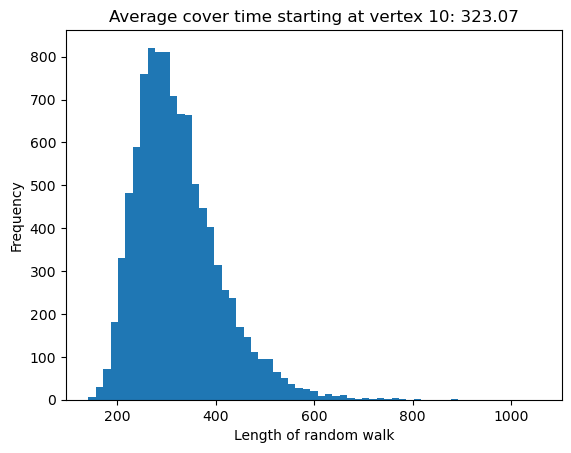

323.0676

In [18]:
rook = Graph(make_chessboard_dict(8, "rook"))
rook.display()

# start in corner
rook.avg_cover_walk(n = 10000, starting_vertex = 0, bin_size = 15, filename = "exports/chess/rook_corner")

# start in middle
rook.avg_cover_walk(n = 10000, starting_vertex = 10, bin_size = 15, filename = "exports/chess/rook_middle")

In [19]:
random_graph = Graph({0: [1,7,5], 1: [2, 3, 4], 2: [3, 6], 4: [5], 5: [6]})
random_graph.export_png("exports/random_graph_title")

In [20]:
random_graph = Graph({0: [1,7,5], 1: [2, 3, 4], 2: [3, 6]})


random_graph.graphviz.node("4", color = 'blue', penwidth = '3')
random_graph.graphviz.node("5", color = 'blue', penwidth = '3')
random_graph.graphviz.node("6", color = 'blue', penwidth = '3')
#random_graph.graphviz.node("3", color = 'blue', penwidth = '3')
path = ["4", "5", "6"]
for i in range(len(path) - 1):
    random_graph.graphviz.edge(path[i], path[i+1], color='blue', penwidth='3')
    
random_graph.export_png("exports/random_graph_path")

In [21]:
random_graph = Graph({0: [1,7,5], 1: [2, 3, 4], 2: [3, 6], 4: [5], 5: [6]})

random_graph.graphviz.node("1", color = 'blue', style = 'filled', fillcolor='gray', penwidth = '3')
random_graph.graphviz.node("4", color = 'blue', penwidth = '3')
random_graph.graphviz.node("3", color = 'blue', penwidth = '3')
random_graph.graphviz.node("0", color = 'blue', penwidth = '3')
random_graph.graphviz.node("2", color = 'blue', penwidth = '3')
random_graph.export_png("exports/random_graph_adjacent")


In [22]:
random_graph2 = Graph({0: [1,7,5], 1: [0, 2, 3, 4], 2: [1, 3, 6], 3: [1,2], 4: [1, 5], 5: [0, 4, 6], 6: [2,5], 7: [0]})

random_graph2.make_path_gif()

Cover Time: 46
[0, 1, 2, 1, 2, 1, 2, 3, 2, 1, 2, 3, 4, 5, 6, 5, 4, 3, 4, 5, 6, 5, 4, 3, 4, 3, 4, 3, 4, 5, 4, 3, 4, 5, 6, 7, 6, 7, 8, 7, 6, 7, 6, 7, 8, 9]


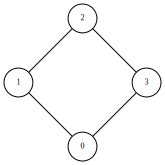

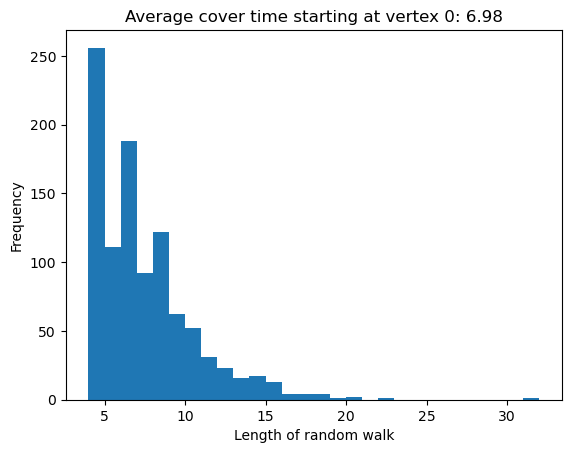

6.98

In [26]:

square = Graph.make_classic(4, "cycle")
square.display()
square.export_png("exports/conjecture/square")



# start in corner
square.avg_cover_walk(n = 1000, starting_vertex = 0, bin_size = 1, filename = "exports/conjecture/square_chart")



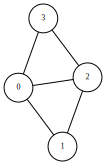

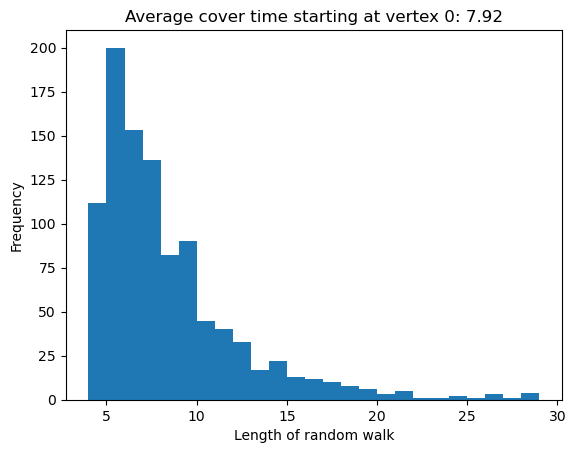

7.916

In [27]:
square_x = Graph({0: [1, 3], 1: [0, 2], 2: [1, 3], 3: [0, 2], 0: [2], 2: [0]})
square_x.display()
square_x.export_png("exports/conjecture/square_x")

square_x = Graph({0: [1, 3, 2], 1: [0, 2], 2: [1, 3, 0], 3: [0, 2]})
square_x.avg_cover_walk(n = 1000, starting_vertex = 0, bin_size = 1, filename = "exports/conjecture/square_x_chart")
